In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True

# Set fonts for Matplotlib
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Courier'
plt.rcParams['font.size'] = 11
width_cm = 15
height_cm = 8
# Convert centimeters to inches
width_in = width_cm / 2.54
height_in = height_cm / 2.54
import seaborn as sns
sns.set_theme()
figsize= (width_in, height_in)



import os
import numpy as np
import pandas as pd 
import wandb
from metrics.plotting_utils import save_plot, get_history_from_project, save_csv, get_dataset_name_mapping
from ood_detection.config import Config
from datasets.config import DATASETS_DICT
api = wandb.Api()
frame_template = "thesis-far-ood-{}"

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Plots for Far OOD
1. 
2. 
3. Per Temp: Mean per Dataset + std, Min per Dataset (+ distance), Max per Dataset (+ distance)
4. Top X + Distances, Flop X + Distances
5. Full plot of all for appendix

In [2]:
# raise ValueError # not execute, needs time
def prep_far_ood(run):
    download_template = 'thesis-far-ood-{}'
    download_name = download_template.format(run)
    working_df = get_history_from_project(download_name, set_name_index=False)
    working_df['ID'] = working_df.name.apply(lambda x: x.split("-")[0])
    working_df['OOD'] = working_df.name.apply(lambda x: x.split("-")[1])
    working_df = working_df.rename(columns={'AUROC':run.upper()}).set_index('name', drop=True)
    return working_df

def get_grouped_auroc_df(df, grouper, metric):
    if metric == 'mean':
        return df.groupby(grouper).mean(numeric_only = True)
    if metric == 'max':
        return df.groupby(grouper).max(numeric_only = True)
    if metric == 'min':
        return df.groupby(grouper).min(numeric_only = True)

def load_and_group(run, grouper, metric):
    df = prep_far_ood(run)
    return get_grouped_auroc_df(df, grouper, metric)

            
def get_all_finished_runs(methods, runs):
    dfs = {}
    for method in methods:
        for run in runs:
            if method == 'mls' and run != '1.0':
                continue
            name = method +'-'+ run
            print(f"Loading {name}")
            try:
                df = prep_far_ood(name)
                assert len(df) == 132
                dfs[name] = df
            except:
                print(f"{name} not finished yet")
                continue
    return dfs

def get_merged_df(df_dict, grouper, metric):
    dfs = []
    for df in df_dict.values():
        dfs.append(get_grouped_auroc_df(df, grouper, metric))
    return pd.concat(dfs, axis=1)

In [3]:
# collect ...
methods = ['msp', 'mls']
runs = ['0.01', '1.0', '100.0']
dfs = get_all_finished_runs(methods, runs)

Loading msp-0.01
Loading msp-1.0
Loading msp-100.0
Loading mls-1.0


In [4]:
# save grouped plots
groups = ['ID', 'OOD']
strats = ['mean','max','min']
mappings = get_dataset_name_mapping()

for group in groups:
    for strat in strats:
        df = get_merged_df(dfs, group, strat).rename(index= mappings)
        save_csv(df.round(3), '5_1', f'{group}_{strat}')
        save_csv(df.round(3).T, '5_1_T', f'{group}_{strat}')

In [5]:
mappings = get_dataset_name_mapping()

df = get_merged_df(dfs, 'ID', 'mean').rename(index=mappings)

In [6]:
mcm_df = df.copy()

In [7]:
mcm_df.mean(axis=1)

ID
Caltech CUB      0.926053
Caltech101       0.877201
CIFAR10          0.798079
CIFAR100         0.709803
DTD              0.886248
Fashion MNIST    0.921390
Flowers102       0.879924
GTSRB            0.686699
TinyImagenet     0.721684
MNIST            0.698518
Stanford Cars    0.987380
SVHN             0.444451
dtype: float64

In [8]:
mcm_df.max(axis=1)

ID
Caltech CUB      0.998518
Caltech101       0.902955
CIFAR10          0.875550
CIFAR100         0.810137
DTD              0.934755
Fashion MNIST    0.970769
Flowers102       0.996787
GTSRB            0.995142
TinyImagenet     0.745367
MNIST            0.813544
Stanford Cars    0.998555
SVHN             0.799067
dtype: float64

In [9]:
mcm_df

,MSP-0.01,MSP-1.0,MSP-100.0,MLS-1.0
ID,,,,
Caltech CUB,0.786523,0.959091,0.960081,0.998518
Caltech101,0.879231,0.902955,0.902773,0.823847
CIFAR10,0.772837,0.771989,0.771940,0.875550
CIFAR100,0.685841,0.671870,0.671365,0.810137
DTD,0.845364,0.882370,0.882503,0.934755
Fashion MNIST,0.882068,0.916298,0.916426,0.970769
Flowers102,0.783848,0.869158,0.869904,0.996787
GTSRB,0.465133,0.642637,0.643882,0.995142
TinyImagenet,0.744527,0.745367,0.744868,0.651976


/tmp/ipykernel_823/52842880.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.vlines([range(len(mcm_df))], ymin=0, ymax=mcm_df.max(axis=1),color='darkgrey', alpha=0.6)
/tmp/ipykernel_823/52842880.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mcm_df.index, rotation=45, ha='right')


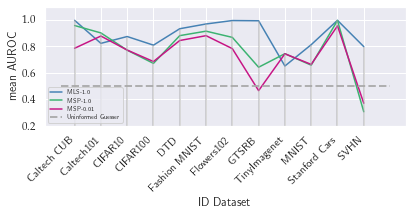

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_1
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_1
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_1


True

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots(figsize=figsize)

# mean = df[value_column].mean().round(3)
# std = u"\u00B1{})".format(df[value_column+'-std'].mean().round(2))
# label = name + f' (\u03bc= {mean}' + std
value_column='MLS-1.0'
ax.plot(mcm_df[value_column], label=value_column, color='steelblue')
value_column ='MSP-1.0'
ax.plot(mcm_df[value_column], label=value_column,color='mediumseagreen')
value_column = 'MSP-0.01'
ax.plot(mcm_df[value_column], label=value_column, color='mediumvioletred')



ax.hlines(0.5, xmin=-.5, xmax=[len(mcm_df)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
ax.vlines([range(len(mcm_df))], ymin=0, ymax=mcm_df.max(axis=1),color='darkgrey', alpha=0.6)

ax.set_ylim(0.2,1.1)
ax.set_xticklabels(mcm_df.index, rotation=45, ha='right')
ax.legend(loc='lower left', fontsize=6)
ax.set_xlabel('ID Dataset')
ax.set_ylabel('mean AUROC')
plt.tight_layout()
plt.show()
save_plot(fig, 'comparisonLines_presentation', '5_1', False)

## Distances

In [11]:
# get distances...
df = get_history_from_project('thesis-far-distances', set_name_index=False)
distances_df = df.copy()
distances_df['ID'] = distances_df.name.apply(lambda x: x.split("-")[0])
distances_df['OOD'] = distances_df.name.apply(lambda x: x.split("-")[1])
distances_df.set_index('name', drop=True, inplace=True)

# get aurocs
auroc_df = prep_far_ood('mls-1.0')
auroc_df.drop(['ID', 'OOD'], axis=1, inplace=True)

# get zsa... tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')
tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')

#add zsa to distances
distances_df['ID ZSA'] = distances_df['ID'].apply(lambda x: tip_df['ZEROSHOT'][x])
distances_df['OOD ZSA'] = distances_df['OOD'].apply(lambda x: tip_df['ZEROSHOT'][x])

# create full table
monstrum = pd.concat([auroc_df, distances_df], axis=1)

In [12]:
monstrum.corr().max()

/tmp/ipykernel_823/1192820532.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  monstrum.corr().max()


MLS-1.0    1.0
clp        1.0
mmd        1.0
ID ZSA     1.0
OOD ZSA    1.0
dtype: float64

### only weak correlation

In [13]:
monstrum.round(3).min()

MLS-1.0          0.277
clp             -3.073
mmd              0.015
ID         caltech cub
OOD        caltech cub
ID ZSA          24.946
OOD ZSA         24.946
dtype: object

In [14]:
monstrum.round(3).max()

MLS-1.0      1.0
clp       -0.049
mmd         0.68
ID          svhn
OOD         svhn
ID ZSA     89.83
OOD ZSA    89.83
dtype: object

In [15]:
monstrum[['MLS-1.0', 'mmd', 'clp', 'ID ZSA', 'OOD ZSA']].corr()['MLS-1.0']
save_csv(monstrum[['MLS-1.0', 'mmd', 'clp', 'ID ZSA', 'OOD ZSA']].corr().round(3)['MLS-1.0'], '5_1','far-corr-matrix')

In [16]:
monstrum[(monstrum['MLS-1.0'] >0.98) & (monstrum['ID'].isin(['stanford cars','caltech cub']))][['MLS-1.0', 'mmd', 'clp']].corr()

,MLS-1.0,mmd,clp
MLS-1.0,1.000000,0.410465,-0.118560
mmd,0.410465,1.000000,0.560099
clp,-0.118560,0.560099,1.000000


### Deeper look into MSP 01

In [17]:
working_df = get_history_from_project(frame_template.format('mls-1.0'), set_name_index=False)

working_df['ID'] = working_df.name.apply(lambda x: x.split("-")[0])
working_df['OOD'] = working_df.name.apply(lambda x: x.split("-")[1])

In [18]:
working_df.groupby('ID').mean('AUROC').sort_values(by='AUROC', ascending=False)

,AUROC
ID,
stanford cars,0.998555
caltech cub,0.998518
flowers102,0.996787
gtsrb,0.995142
fashion mnist,0.970769
dtd,0.934755
cifar10,0.875550
caltech101,0.823847
mnist,0.813544


## Perfectly over 95% on 67!!! combinations --> to easy in many settings or the method is very good

In [19]:
working_df.max()

AUROC                   1.0
name     svhn-stanford cars
ID                     svhn
OOD                    svhn
dtype: object

In [20]:
# count by id
working_df[(working_df['AUROC'] > 0.99)].value_counts('ID')

ID
caltech cub      11
stanford cars    11
flowers102       10
gtsrb            10
fashion mnist     3
cifar10           1
dtd               1
dtype: int64

In [21]:
# count by od
working_df[(working_df['AUROC'] > 0.95)]

,AUROC,name,ID,OOD
2,0.976149,svhn-imagenet,svhn,imagenet
9,0.971963,svhn-caltech cub,svhn,caltech cub
11,0.999986,stanford cars-svhn,stanford cars,svhn
12,1.000000,stanford cars-mnist,stanford cars,mnist
13,0.998066,stanford cars-imagenet,stanford cars,imagenet
...,...,...,...,...
117,0.999729,caltech cub-dtd,caltech cub,dtd
118,0.998458,caltech cub-cifar100,caltech cub,cifar100
119,0.991011,caltech cub-cifar10,caltech cub,cifar10
120,0.997648,caltech cub-caltech101,caltech cub,caltech101


# Not working on: 5 with 50% +-5. 

In [22]:
working_df[(working_df['AUROC'] <0.53) & (working_df['AUROC'] > 0.47)]

,AUROC,name,ID,OOD
38,0.481631,imagenet-fashion mnist,imagenet,fashion mnist


## Confused on only 5

In [23]:
working_df[(working_df['AUROC'] <0.50)]

,AUROC,name,ID,OOD
1,0.466686,svhn-mnist,svhn,mnist
3,0.276946,svhn-gtsrb,svhn,gtsrb
25,0.373910,mnist-gtsrb,mnist,gtsrb
38,0.481631,imagenet-fashion mnist,imagenet,fashion mnist
108,0.456456,cifar10-caltech cub,cifar10,caltech cub


## Look into one run specifically

In [24]:
mls1 = prep_far_ood('mls-1.0')

In [25]:
mls1[(mls1['ID'] == 'cifar100') & (mls1['OOD'] == 'cifar10')]

,MLS-1.0,ID,OOD
name,,,
cifar100-cifar10,0.689235,cifar100,cifar10


In [26]:
mls1[(mls1['ID'] == 'cifar10') & (mls1['OOD'] == 'cifar100')]

,MLS-1.0,ID,OOD
name,,,
cifar10-cifar100,0.865039,cifar10,cifar100


In [27]:
mls1[(mls1['ID'] == 'cifar10') & (mls1['OOD'] == 'svhn')]

,MLS-1.0,ID,OOD
name,,,
cifar10-svhn,0.912709,cifar10,svhn
